# Preprocessing Test

Simple example of spectrum preprocessing before identification.

In [2]:
import numpy as np

from astropy.io import fits
from astropy.table import Table, Column

from desispec.io.spectra import read_spectra
from desitrip.preproc import rebin_flux, rescale_flux

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size=16)

## Simulated Inputs

1. Truth data: spectral templates with extremely bright SNe Ia on top of BGS galaxies.
1. Spect data: high SNR simulated DESI spectra: 800 s observations with no Moon.
1. Coadd data: coadded BRZ camera data.

In [3]:
truth_file = 'bgs_2020-06-23_0800s_001_truth.fits'
spect_file = 'bgs_2020-06-23_0800s_001_spect.fits'
coadd_file = 'bgs_2020-06-23_0800s_001_coadd.fits'

### Monte Carlo Truth

Simulated templates.

In [4]:
hdus = fits.open(truth_file)
wave = hdus['WAVE'].data
flux = hdus['FLUX'].data
targets = Table.read(truth_file, 'TARGETS')
truth = Table.read(truth_file, 'TRUTH')
objtr = Table.read(truth_file, 'OBJTRUTH')

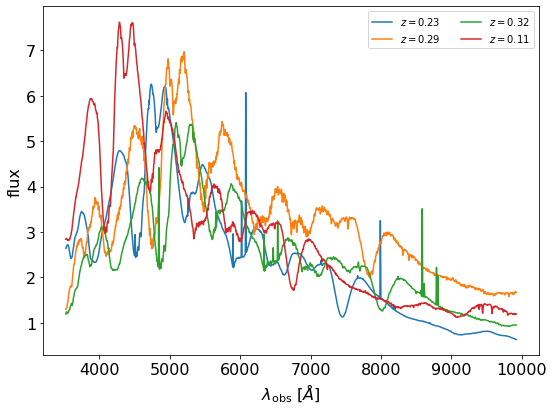

In [5]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

for i in range(6,10):
    z = truth['TRUEZ'][i]
    wemit = wave / (1 + z)
    
    ax.plot(wave, flux[i], label='$z={:.2f}$'.format(z))
    
ax.legend(fontsize=10, ncol=2)

ax.set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
       ylabel='flux')
fig.tight_layout()

### Coadded Spectra

In [6]:
coadds = read_spectra(coadd_file)

In [7]:
wavec = coadds.wave['brz']
fluxc = coadds.flux['brz']
ivarc = coadds.ivar['brz']

In [8]:
fluxc.shape

(100, 6265)

In [9]:
# Condition spectra: remove NaN and spectra with zero flux values.
mask = np.isnan(fluxc).any(axis=1) | (np.count_nonzero(fluxc, axis=1) == 0)
mask_idx = np.argwhere(mask)
fluxc = np.delete(fluxc, mask_idx, axis=0)
ivarc = np.delete(ivarc, mask_idx, axis=0)

In [10]:
fluxc.shape, ivarc.shape

((99, 6265), (99, 6265))

## Rebin and Rescale Fluxes

Rebin on a log scale to effectively downsample the spectra from ~6000 bins to ~600.

Then rescale each spectrum from 0 to 1 to condition them for input to ML classifiers.

In [11]:
rewave, reflux, reivar = rebin_flux(wavec, fluxc, ivarc, minwave=3600., maxwave=9800., nbins=600, log=True)

In [12]:
rsflux = rescale_flux(reflux)

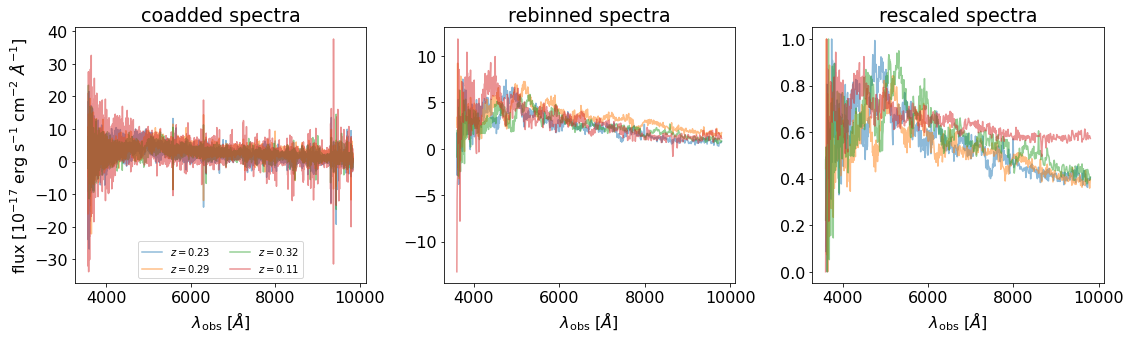

In [13]:
fig, axes = plt.subplots(1,3, figsize=(16,5))

for i in range(6,10):
    z = truth['TRUEZ'][i]
    
    ax = axes[0]
    ax.plot(wavec, fluxc[i], label='$z={:.2f}$'.format(z), alpha=0.5)

    ax = axes[1]
    ax.plot(rewave, reflux[i], alpha=0.5)
    
    ax = axes[2]
    ax.plot(rewave, rsflux[i], alpha=0.5)
    
axes[0].legend(fontsize=10, ncol=2)

axes[0].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
            ylabel=r'flux [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]',
            title='coadded spectra')
axes[1].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
            title='rebinned spectra')
axes[2].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
            title='rescaled spectra')
fig.tight_layout()